In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random

In [2]:
# Import data and inspect it
data = pd.read_csv("nn_train.csv")
data_test = pd.read_csv("nn_test.csv")
print(data.head())
print(data_test.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [3]:
# Transform the data into np array, print the shape
data = np.array(data)
data_test = np.array(data_test)
m, n = data.shape

# Randomly shuffle for each full run
np.random.shuffle(data)

# See that the dimensions are 42000 rows(data inputs/pictures in this case) and 785 columns (784 features/pixels + 1 label)
print(m, n)

42000 785


In [4]:
# Split into data_dev to use for test, transpose it so that each column is an input
data_dev = data[0:1000].T
data_test_dev = data_test.T

# Set the label for the test data as the first row of the transposed data
Y_dev = data_dev[0]

# Define the features set of the test data and rescale between 0 and 1 by dividing with 255
X_dev = data_dev[1:n]
X_dev = X_dev / 255.
X_dev_test = data_test_dev / 255.
print(len(X_dev), len(X_dev_test))

784 784


In [5]:
# Define the training data as the 41000 next rows, then transpose
data_train = data[1000:m].T

# Define the label train data as the first row of the transposed dataset
Y_train = data_train[0]

# Define the features set and their values for the train dataset and rescale between 0 and 1 by dividing by 255
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape
print(X_train)
print(Y_train.shape) # Label for the train dataset

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(41000,)


In [6]:
# Define random weights and biases
def init_params():
    """
    Initialize the weights and biases from a uniform distribution of -1 to 1
    
    Args:
        None
        
    Returns:
        W1: np.array of dimensions ([neurons of next layer] x [number of features]) --> matrix
        b1: np.array of dimensions ([nueurons of next layer] x 1) --> vector
        W2: np.array of dimensions ([neurons of next layer] x [neurons of previous layer]) --> matrix
        b1: np.array of dimensions ([nueurons of next layer] x 1) --> vector        
    """
   
    W1 = np.random.rand(196, 784) - 0.5
    b1 = np.random.rand(196, 1) - 0.5
    W2 = np.random.rand(10, 196) - 0.5 
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

# Define ReLU activation function    
def ReLU(Z):
    """
    Calculate ReLU
    
    Args:
        Z (np.array): The only parameter
        
    Returns:
        np.array: Each positive element stays the same while the negative ones become 0
    """
    
    # ReLU([1 3 -3 0 -2 4]) 
    # result = [1 3 0 0 0 4]
    return np.maximum(0, Z)

def sigmoid(Z):
    """Define the sigmoid func

    Args:
        Z (np.array): Array/layer what we want to activate

    Returns:
        np.array: Activated layer with sigmoid
    """    
    return 1 / (1 + np.exp(-Z))
   
# Define softmax, it is a probability density function (pdf)    
def softmax(Z):
    """
    Calculate softmax
    
    Args:
        Z (np.array): The only parameter
        
    Returns:
        np.array: Same dimension as input, but all scaled so that the sum of elements equals 1 (pdf)
    """
    
    # softmax([1, 2, -3, 4, 0])
    # result array([4.13393728e-02, 1.12372066e-01, 7.57157024e-04, 8.30323499e-01, 1.52079054e-02])
    return np.exp(Z) / sum(np.exp(Z))
    
 
# Define forward propagation calculations   
def forward_prop(W1, b1, W2, b2, X):
    """
    Calculate the steps for our 2 layers (1 hidden and 1 output)
    
    Args:
        W1 (array): First weights matrix
        b1 (array): First bias vector
        W2 (array): Second weights matrix
        b2 (array): Second bias vector
        X (array): Input (data) matrix 
    """
    
    Z1 = W1.dot(X) + b1
    
    # Activate second layer (ReLU)
    A1 = ReLU(Z1)
    
    Z2 = W2.dot(A1) + b2
    
    # Activate output layer (softmax)
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2
    
    
# Define our labels array    
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

# Define the derivative of ReLU
def deriv_ReLU(Z):
    return Z > 0

def deriv_sigmoid(Z):
    return np.exp(-Z) / (1 + np.exp(-Z))**2
 
# Define the calculations for backward propagation    
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    """
    Calculate the increments that we need to adjust in the weights and biases
    
    Args:
        Z1 (array): First calculation W1 * X + b1 output for second(hidden) layer
        A1 (array): Activation of the second(hidden) layer
        Z2 (array): Second calculation W2 * A1 + b2 output for third(last) layer
        A2 (array): Activation of third(last) layer
        W1 (array): First weights matrix
        W2 (array): Second weights matrix
        X (array): Input/features data matrix
        Y (array): Labels data matrix
        
    Returns:
        dW1 (array): Increment change for first weights matrix
        db1 (array): Increment change for first bias vector
        dw2 (array): Increment change for second weights matrix
        db2 (array): Increment change for second bias vector
    """
    
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2


# Update the weights and biases according to learning rate (alpha)
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2    

In [7]:
# Define the classification of the prediction
def get_predictions(A2):
    """
    Gives the prediction
    
    Args:
        A2 (array): This array is a vector and a probability density function for the number of our classes
        
    Returns:
        np.argmax(A2, 0) (int): Outputs the index with the highest probability
    """
    return np.argmax(A2, 0)


# Define how to get the accuracy of the model
def get_accuracy(predictions, Y):
    """
    Gives us the accuracy of the model when we have a dataset with the label column (doesn't apply in test datasets without the label column)
    
    Args:
        predictions (array): First variable, it is the prediction of the model
        Y (array): Second variable, it is the array with the labels
        
    Returns:
        np.sum(predictions == Y) / Y.size (float): Counts the cases when our prediction was equal to the label, then we divide by total cases Y.size
        
    """
    # print(predictions, Y)
    return np.sum(predictions == Y) / Y.size


# Define the gradient descent used to update the weights and biases 
def grad_descent(X, Y, iterations, alpha):
    """
    Calculate and update the weights and biases
    
    Args:
        X (array): The features set
        Y (array): The label(s) set
        iterations (int): Number of iterations to adjust the weights and biases, otherwise called epochs
        alpha (float): Factor of used to rescale the increments of dW1, db1, dW2, db2, also called learning rate
        
    Returns:
        W1 (array): Updated W1 weights matrix
        b1 (array): Updated b1 bias vector
        W2 (array): Updated W2 weights matrix
        b2 (array): Updated b2 bias vector
    """
    # Generate the weights and biases
    W1, b1, W2, b2 = init_params()
    
    # Loop through the iterations/epochs
    for i in range(iterations):
        
        # Calculate and store results from forward propagation
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)      
        
        # From our results of forward propagation and our weights and biases calculate the increment changes for the weights and biases  
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        
        # Update our weights and biases according to alpha (learning rate)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        # For every 10 iterations, print the iteration number, the prediction of the model and the accuracy of the model
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print('Accuracy: ', round(get_accuracy(predictions, Y), 4) * 100, '%')
    return W1, b1, W2, b2    
        

In [8]:
# Train the model
W1, b1, W2, b2 = grad_descent(X_train, Y_train, 1000, 0.6)

Iteration:  0
Accuracy:  11.3 %
Iteration:  10
Accuracy:  27.3 %
Iteration:  20
Accuracy:  36.08 %
Iteration:  30
Accuracy:  42.51 %
Iteration:  40
Accuracy:  50.17 %
Iteration:  50
Accuracy:  58.3 %
Iteration:  60
Accuracy:  73.35000000000001 %
Iteration:  70
Accuracy:  78.10000000000001 %
Iteration:  80
Accuracy:  78.35 %
Iteration:  90
Accuracy:  81.77 %
Iteration:  100
Accuracy:  82.72 %
Iteration:  110
Accuracy:  84.22 %
Iteration:  120
Accuracy:  85.42999999999999 %
Iteration:  130
Accuracy:  86.26 %
Iteration:  140
Accuracy:  87.03999999999999 %
Iteration:  150
Accuracy:  87.63 %
Iteration:  160
Accuracy:  88.21 %
Iteration:  170
Accuracy:  88.73 %
Iteration:  180
Accuracy:  89.11 %
Iteration:  190
Accuracy:  89.51 %
Iteration:  200
Accuracy:  89.92 %
Iteration:  210
Accuracy:  90.25 %
Iteration:  220
Accuracy:  90.47 %
Iteration:  230
Accuracy:  90.72 %
Iteration:  240
Accuracy:  90.99000000000001 %
Iteration:  250
Accuracy:  91.2 %
Iteration:  260
Accuracy:  91.39 %
Iteration:

In [9]:
# Define a function to output a prediction after having trained the model
def make_predictions(X, W1, b1, W2, b2):
    """
    Calculate preditction
    
    Args:
        X (array): The features set that we want to make a prediction on
        W1 (array): The first weights matrix
        b1 (array): The first bias vector
        W2 (array): The second weights matrix
        b2 (array): The second bias vector
        
    Returns:
        Outputs the prediction (int)
    """
    
    # Calculate A2 (Activation of the output layer) from the forward propagation
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    
    # Get prediction from A2
    predictions = get_predictions(A2)
    # outs = A2
    return predictions, A2


# Define a function to test a prediction 
def test_prediction(index, W1, b1, W2, b2):
    """
    Calculation to give a prediction and show the image
    
    Args:
        index (int): Index of the input that we want to predict
        W1 (array): The first weights matrix
        b1 (array): The first bias vector
        W2 (array): The second weights matrix
        b2 (array): The second bias vector
        
    Returns:
        Prediction of the digit (int)
        Image of the digit using plt
    """
    
    # Select the image by slicing the features dataset through the index
    current_image = X_dev_test[:, index, None]
    
    # Make a prediction of the input with the given index
    prediction, A2 = make_predictions(X_dev_test[:, index, None], W1, b1, W2, b2)
    # label = Y_dev[index]
    print("Prediction: ", prediction)
    print(np.round(A2, 3))
    # for i in outs:
    #    print(round(i[0],4))
    # print("Label: ", label)
    
    # Reshape our image from a vector fo 784 elements to a 28 x 28 grid, multiply by 255 to rescale to original
    current_image = current_image.reshape((28, 28)) * 255
    
    # Plot the image/input
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

In [10]:
# Get accuracy and output of the prediction
dev_predictions, _ = make_predictions(X_dev, W1, b1, W2, b2)
# get_accuracy(dev_predictions, Y_dev)
print('Accuracy: ', round(get_accuracy(dev_predictions, Y_dev), 4) * 100, '%')

Accuracy:  94.19999999999999 %


In [11]:
print(len(X_dev_test[1]))

28000


Prediction:  [0]
[[0.978]
 [0.   ]
 [0.019]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.002]
 [0.   ]
 [0.   ]
 [0.   ]]


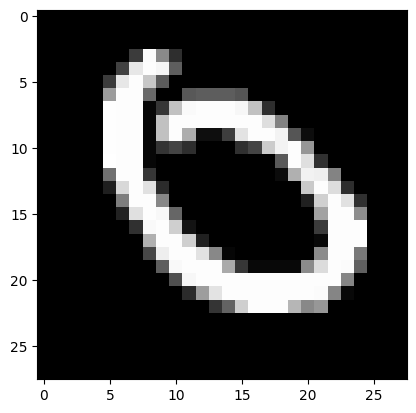

In [20]:
# Test any image/input that you choose
test_prediction(random.randint(0,28000), W1, b1, W2, b2)
